# Import


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image
%matplotlib inline

# Dataset

In [2]:
train_dir = '/home/username/Documents/KaggleDogsCats/train'
test_dir = '/home/username/Documents/KaggleDogsCats/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Processing Dataset

In [3]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

In [4]:
dataloader = DataLoader(catdogs, batch_size = 10, shuffle=True, num_workers=0)

# Samples of Traning Data

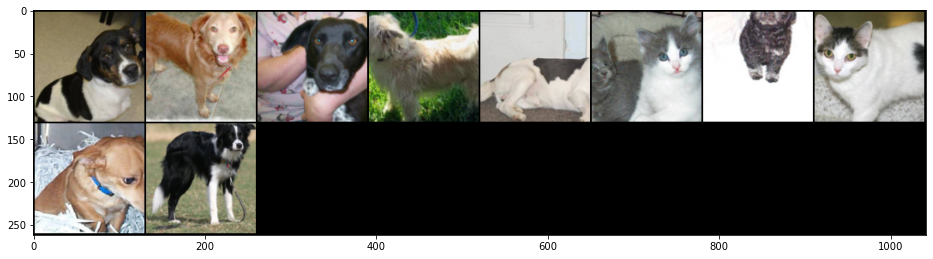

In [129]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()


# Training Model

In [6]:
device = 'cuda'
model = torchvision.models.densenet121(pretrained=True)

In [7]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

[Epoch 1/3] Iteration 200 -> Train Loss: 0.7724, Accuracy: 0.300
[Epoch 1/3] Iteration 400 -> Train Loss: 0.6949, Accuracy: 0.600
[Epoch 1/3] Iteration 600 -> Train Loss: 0.6849, Accuracy: 0.600
[Epoch 1/3] Iteration 800 -> Train Loss: 0.6261, Accuracy: 0.500
[Epoch 1/3] Iteration 1000 -> Train Loss: 0.6243, Accuracy: 0.800
[Epoch 1/3] Iteration 1200 -> Train Loss: 0.5808, Accuracy: 0.800
[Epoch 1/3] Iteration 1400 -> Train Loss: 0.5714, Accuracy: 0.500
[Epoch 1/3] Iteration 1600 -> Train Loss: 0.5346, Accuracy: 0.900
[Epoch 1/3] Iteration 1800 -> Train Loss: 0.4963, Accuracy: 0.900
[Epoch 1/3] Iteration 2000 -> Train Loss: 0.4936, Accuracy: 0.900
[Epoch 1/3] Iteration 2200 -> Train Loss: 0.4743, Accuracy: 0.800
[Epoch 1/3] Iteration 2400 -> Train Loss: 0.4703, Accuracy: 1.000
[Epoch 2/3] Iteration 2600 -> Train Loss: 0.4511, Accuracy: 0.800
[Epoch 2/3] Iteration 2800 -> Train Loss: 0.4329, Accuracy: 0.800
[Epoch 2/3] Iteration 3000 -> Train Loss: 0.4394, Accuracy: 0.900
[Epoch 2/3] It

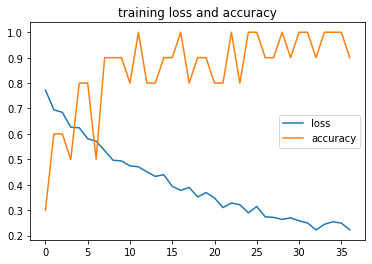

In [8]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    torch.cuda.empty_cache()
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [9]:
filename_pth = 'densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

#Transform the test dataset
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 10, shuffle=False, num_workers=4)

# Samples from Test Data and Model Evaluation

In [11]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})


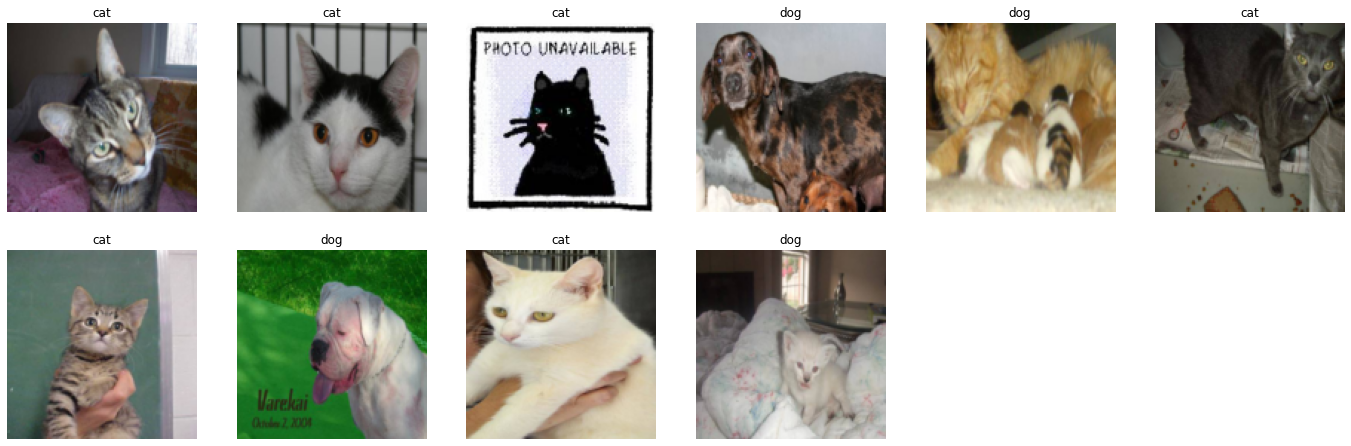

In [12]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

# Install Captum Library

In [15]:
conda install captum -c pytorch

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install captum

Note: you may need to restart the kernel to use updated packages.


In [16]:
torch.manual_seed(123)
np.random.seed(123)


In [26]:
import gc

gc.collect()

14788

# DeepLift

In [27]:

torch.cuda.empty_cache()


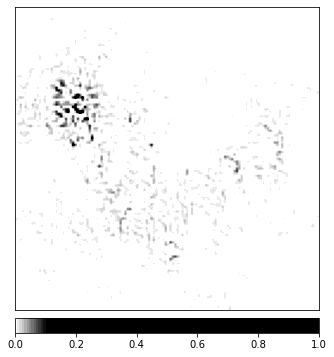

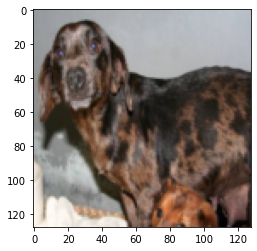

Convergance Delta:  tensor([-2.0932], device='cuda:0')


In [116]:
from captum.attr import DeepLift
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

input = samples[3].unsqueeze(0)
input.requires_grad = True

output = model(input)
pred_label_idx = torch.argmax(output, dim=1)
baseline = torch.zeros(input.shape).cuda()

dl = DeepLift(model)
attributions, delta = dl.attribute(input,baseline , 
                        target=pred_label_idx, return_convergence_delta=True)


default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.10, '#000000'),
                                                  (1, '#000000')], N=128)

_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                            
                            input.cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=2)

plt.imshow(np.transpose(samples[3].cpu().numpy(), (1,2,0)))
plt.show()
print("Convergance Delta: ",delta)

# DeepLift with Smoothgrad

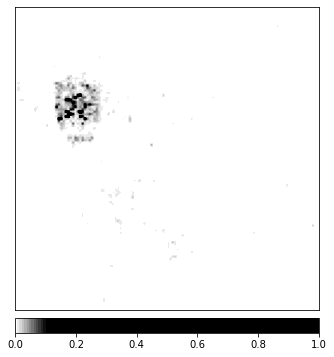

In [117]:
from captum.attr import (
      NoiseTunnel,
)

nt = NoiseTunnel(dl)
attributions, delta = nt.attribute(input, nt_type='smoothgrad_sq', 
                    stdevs=0.10, n_samples=10,baselines=baseline, 
                 target=pred_label_idx, return_convergence_delta=True)


_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                            
                            input.cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=2)


# Integrated Gradient

In [118]:
from captum.attr import IntegratedGradients

input = samples[6].unsqueeze(0)
input.requires_grad = True
baseline = torch.zeros(input.shape).cuda()


output = model(input)
pred_label_idx = torch.argmax(output, dim=1)


ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input, baseline, 
                                   target=pred_label_idx, n_steps=20, 
                                   return_convergence_delta=True)

print('Convergence Delta:', delta)

Convergence Delta: tensor([0.0810], device='cuda:0', dtype=torch.float64)


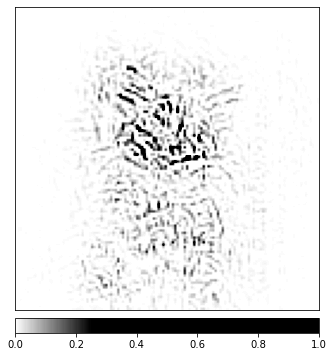

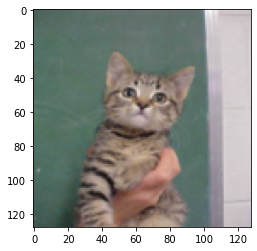

In [119]:
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                        [(0, '#ffffff'),
                                        (0.25, '#000000'),
                                       (1, '#000000')], N=256)

_ = viz.visualize_image_attr(
    np.transpose(attributions.squeeze().cpu().detach().numpy(), 
    (1,2,0)),
                            
    input.cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
plt.imshow(np.transpose(samples[6].cpu().numpy(), (1,2,0)))
plt.show()

# Integrated Gradient with Smoothgrad Square

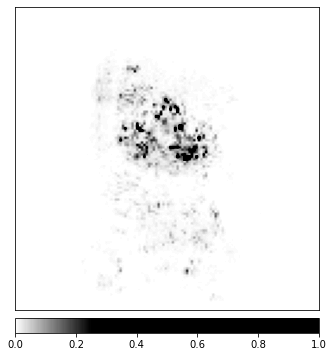

In [32]:
from captum.attr import NoiseTunnel

nt = NoiseTunnel(ig)
attributions, delta = nt.attribute(input, nt_type='smoothgrad_sq', 
                        stdevs=0.02, n_samples=10,n_steps=10,
                        baselines=baseline, target=pred_label_idx,
                        return_convergence_delta=True)


_ = viz.visualize_image_attr(
    np.transpose(attributions.squeeze().cpu().detach().numpy(), 
    (1,2,0)),
                            
    input.cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

# Saliency Map

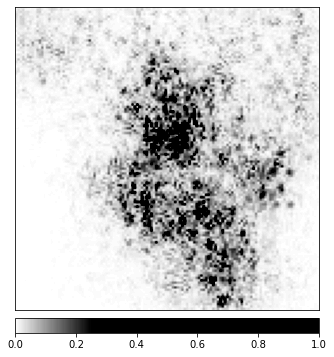

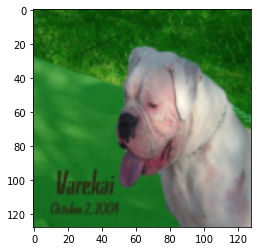

In [124]:
from captum.attr import (
    
    Saliency
      

 )
torch.cuda.empty_cache()

input = samples[7].unsqueeze(0)
input.requires_grad = True
output = model(input)
pred_label_idx = torch.argmax(output, dim=1)



saliency = Saliency(model) #takes one input
attribution= saliency.attribute(input,target=pred_label_idx)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0)),
                            
                            input.cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
plt.imshow(np.transpose(samples[7].cpu().numpy(), (1,2,0)))
plt.show()

# Saliency Map with Smoothgrad Square

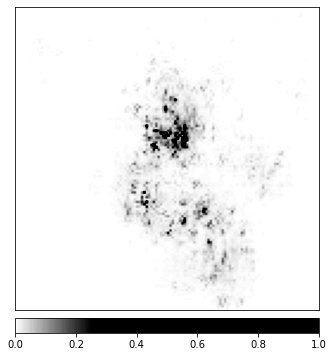

In [125]:
from captum.attr import (
      
      NoiseTunnel
)

nt = NoiseTunnel(saliency )
attributions = nt.attribute(input, nt_type='smoothgrad_sq', stdevs=0.02, n_samples=10,
target=pred_label_idx)


_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                            
                            input.cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

# DeepLiftShap

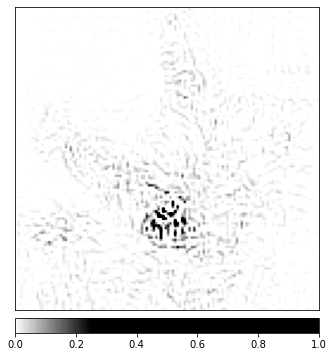

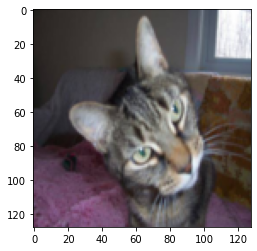

In [58]:
from captum.attr import (
    
    DeepLiftShap
      

 )
torch.cuda.empty_cache()

input = samples[:2]

baseline = torch.zeros(input.shape).cuda()
output = model(input[0].unsqueeze(0))
pred_label_idx = torch.argmax(output, dim=1)

dl_s = DeepLiftShap(model)
attributions,delta = dl_s.attribute(input[0].unsqueeze(0), baseline, target=pred_label_idx, return_convergence_delta=True)



default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                            
                            input[0].cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
plt.imshow(np.transpose(samples[0].cpu().numpy(), (1,2,0)))
plt.show()

# Gradient Shap

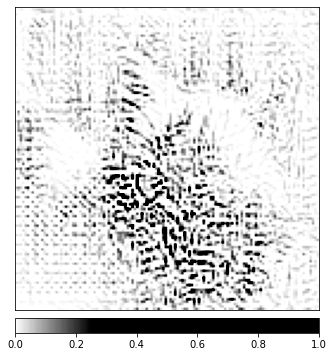

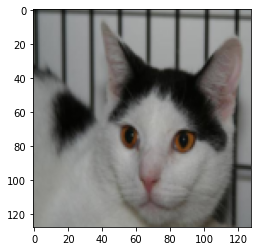

In [126]:
from captum.attr import (
    
    GradientShap
      

 )

torch.cuda.empty_cache()

input = samples[:10]

baseline = torch.zeros(input.shape).cuda()
output = model(input[1].unsqueeze(0))
pred_label_idx = torch.argmax(output, dim=1)

dl_s = DeepLiftShap(model)
attributions,delta = dl_s.attribute(input[1].unsqueeze(0), baseline, target=pred_label_idx, return_convergence_delta=True)



default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                            
                            input.cpu().detach().numpy(), method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
plt.imshow(np.transpose(samples[1].cpu().numpy(), (1,2,0)))
plt.show()

# Layer Integrated Gradients 

In [127]:
from captum.attr import LayerIntegratedGradients


lig = LayerIntegratedGradients(model, model.classifier)

input = samples[7].unsqueeze(0)
input.requires_grad = True
baseline = torch.zeros(input.shape).cuda()

output = model(input)
pred_label_idx = torch.argmax(output, dim=1)

attribution = lig.attribute(input,baselines=baseline, target=pred_label_idx)
print(attribution.shape)
print(attribution)

torch.Size([1, 2])
tensor([[-0.0000, 2.5714]], device='cuda:0', dtype=torch.float64)


# Neuron DeepLift

In [128]:
from captum.attr import NeuronDeepLift

NeuD = NeuronDeepLift(model, model.features.conv0)
input = samples[7].unsqueeze(0)
input.requires_grad = True
output = model(input)
pred_label_idx = torch.argmax(output, dim=1)

attribution = lig.attribute(input, 2, target=pred_label_idx)
print(attribution.shape)
print(attribution)

torch.Size([1, 2])
tensor([[-0.0000, 2.8948]], device='cuda:0', dtype=torch.float64)


# Reference

https://www.kaggle.com/rsradhakrishnan/cats-vs-dogs-densenet

https://github.com/pytorch/captum
